# USAD

## Environment

In [1]:
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


In [2]:
!git clone https://github.com/manigalati/usad

In [3]:
%cd usad

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [5]:
!nvidia-smi -L

device = get_default_device()

GPU 0: Quadro P6000 (UUID: GPU-e16b9553-c966-4659-d528-7376969c0e91)
GPU 1: Quadro P6000 (UUID: GPU-def1ffb6-415d-a3f6-288b-94256f1ba88f)
GPU 2: GeForce GTX 1080 Ti (UUID: GPU-075162a2-c2cc-7757-e07d-e1260458102e)
GPU 3: GeForce GTX 1080 Ti (UUID: GPU-078c9ebd-10e3-2644-2267-bfcf3135c6a1)
GPU 4: GeForce GTX 1080 Ti (UUID: GPU-db4d0970-82a3-4f24-d69f-423377f7d3c0)
GPU 5: GeForce GTX 1080 Ti (UUID: GPU-945cc499-5f5f-ee9f-5b21-69a0e2e06535)
GPU 6: GeForce GTX 1080 Ti (UUID: GPU-07966339-f324-1615-decf-f4825e865008)
GPU 7: GeForce GTX 1080 Ti (UUID: GPU-dfa6e9f2-3de4-2115-3363-4329ff29ba3f)


## EDA - Data Pre-Processing

### Download dataset

In [6]:
!mkdir input
#normal period
!python gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/

mkdir: cannot create directory 'input': File exists
input/SWaT_Dataset_Normal_v1.csv [Exists]
input/SWaT_Dataset_Attack_v0.csv [Exists]


### Normal period

In [7]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(495000, 51)

In [8]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [9]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [10]:
normal.head(2)

0         1    2    3    4         5         6         7    8    9   ...  \
0  0.0  0.005294  0.5  0.0  0.0  0.012291  0.075099  0.002009  0.0  0.5  ...   
1  0.0  0.005407  0.5  0.0  0.0  0.012291  0.075099  0.002009  0.0  0.5  ...   

    41   42   43        44   45        46        47   48   49   50  
0  0.0  0.0  0.0  0.000814  0.0  0.001217  0.000147  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.000814  0.0  0.001217  0.000147  0.0  0.0  0.0  

[2 rows x 51 columns]

### Attack

In [11]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(449919, 51)

In [12]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [13]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [14]:
attack.head(2)

0         1    2    3    4         5         6         7         8   \
0  0.884144  0.577133  1.0  1.0  0.0  0.496158  0.188845  0.064088  0.982899   
1  0.891145  0.577190  1.0  1.0  0.0  0.496158  0.188845  0.064088  0.982899   

    9   ...        41   42   43        44        45        46        47   48  \
0  1.0  ...  0.970903  1.0  0.0  0.946125  0.449782  0.944116  0.000073  0.0   
1  1.0  ...  0.970903  1.0  0.0  0.946125  0.449782  0.944521  0.000073  0.0   

    49   50  
0  0.0  0.0  
1  0.0  0.0  

[2 rows x 51 columns]

### Windows

In [15]:
window_size=12

In [16]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494988, 12, 51)

In [17]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449907, 12, 51)

## Training

In [18]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [19]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0261, val_loss2: 0.0263
Epoch [1], val_loss1: 0.0206, val_loss2: -0.0026
Epoch [2], val_loss1: 0.0323, val_loss2: -0.0210
Epoch [3], val_loss1: 0.0389, val_loss2: -0.0281
Epoch [4], val_loss1: 0.0423, val_loss2: -0.0310
Epoch [5], val_loss1: 0.0293, val_loss2: -0.0217
Epoch [6], val_loss1: 0.0593, val_loss2: -0.0476
Epoch [7], val_loss1: 0.0582, val_loss2: -0.0514
Epoch [8], val_loss1: 0.0588, val_loss2: -0.0537
Epoch [9], val_loss1: 0.0592, val_loss2: -0.0546
Epoch [10], val_loss1: 0.0595, val_loss2: -0.0554
Epoch [11], val_loss1: 0.0607, val_loss2: -0.0570
Epoch [12], val_loss1: 0.0629, val_loss2: -0.0594
Epoch [13], val_loss1: 0.0632, val_loss2: -0.0600
Epoch [14], val_loss1: 0.1583, val_loss2: -0.1409
Epoch [15], val_loss1: 0.1570, val_loss2: -0.1452
Epoch [16], val_loss1: 0.1564, val_loss2: -0.1460
Epoch [17], val_loss1: 0.1568, val_loss2: -0.1470
Epoch [18], val_loss1: 0.1573, val_loss2: -0.1481
Epoch [19], val_loss1: 0.1577, val_loss2: -0.1490
Epoch [20],

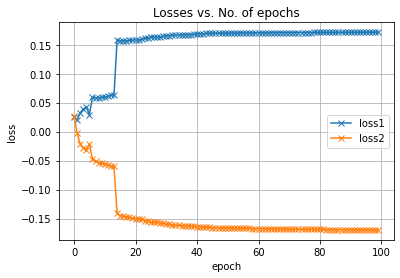

In [20]:
plot_history(history)

In [21]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [22]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [23]:
results=testing(model,test_loader)

In [24]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [25]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [26]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

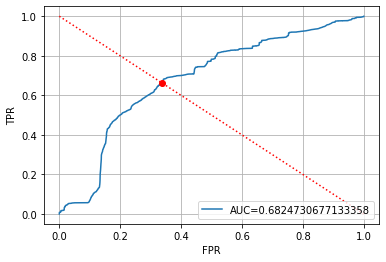

In [27]:
threshold=ROC(y_test,y_pred)